In [1]:
!pip -q install jcopml

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

# Import Data

In [3]:
df = pd.read_csv('/kaggle/input/taxi-fare/taxi_fare.csv', parse_dates=['pickup_datetime']) # di lakukan parse tanggal dan waktu agar lebih mudah memecah ke data tanggal dan waktu

pickup_dt = df.pickup_datetime.dt # terdapat .dt karena sudah dilakukan parse pada saat melakukan read data
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset Splitting

In [4]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train.shape, X_test.shape, X_train.shape, y_train.shape

((15135, 6), (3784, 6), (15135, 6), (15135,))

# Training

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [6]:
rsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [10]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['passenger_count', 'distance', 'year']), 
    ('categoric', cat_pipe(encoder='onehot'), ['month', 'day', 'hour']) 
])

# Pipeline
en_pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

# Parameter Tunning
model = RandomizedSearchCV(en_pipeline, rsp.enet_poly_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+05, tolerance: 9.343e+01
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.032e+05, tolerance: 9.439e+01
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.147e+05, tolerance: 9.311e

{'algo__alpha': 0.0005397956855996446, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8331949117361646, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7117941364201046 0.7084519502461356 0.725423809302792


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+05, tolerance: 1.405e+02
  model = cd_fast.enet_coordinate_descent(


# Feature Importance

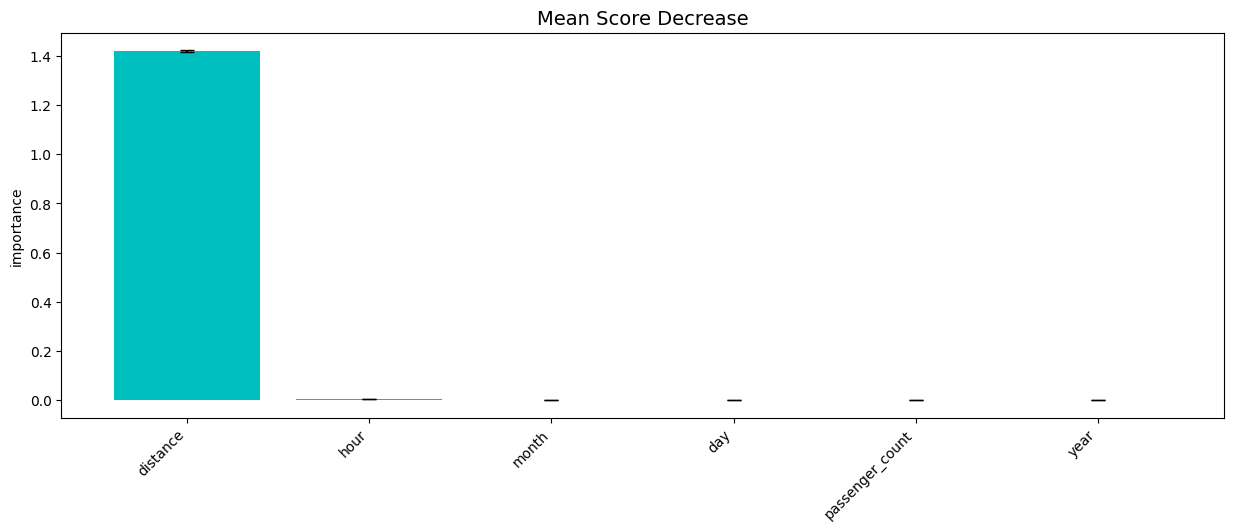

In [11]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Evaluation

In [12]:
from jcopml.plot import plot_residual

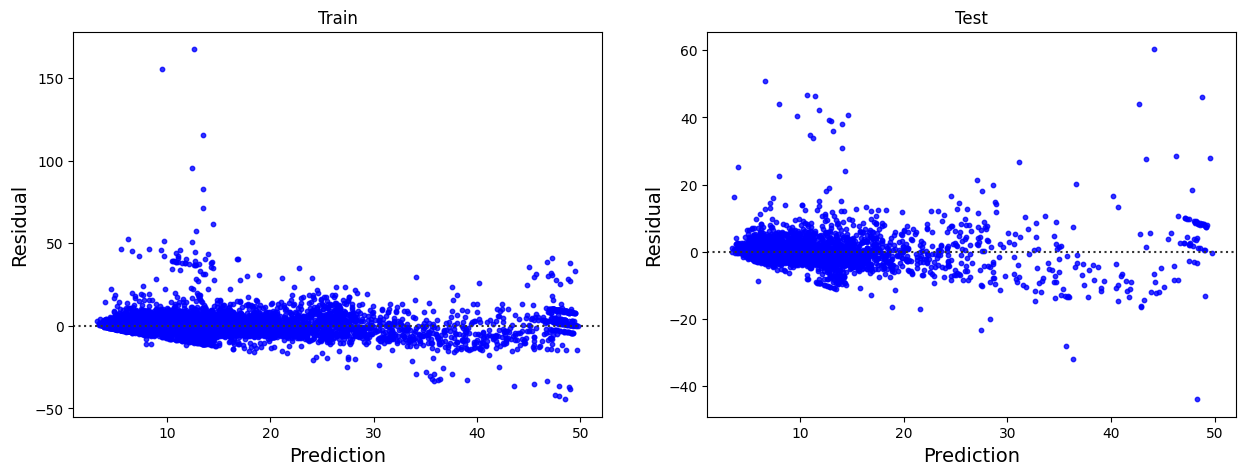

In [13]:
plot_residual(X_train, y_train, X_test, y_test, model)

### Masih saja ada unbalanced, mari kita cek datanya

In [15]:
df_analysis = df.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analysis['fare'] = y_train
df_analysis['error'] = error
df_analysis.sort_values('error', ascending=False).head(10)

,fare_amount,passenger_count,year,month,day,hour,distance,fare,error
1335,180.00,1.0,2013,1,2,20,0.000000,180.00,167.374648
1483,165.00,1.0,2009,8,4,21,0.000416,165.00,155.533343
6630,128.83,1.0,2014,5,4,1,0.000000,128.83,115.367221
14142,108.00,1.0,2014,12,4,10,0.045860,108.00,95.577804
12915,96.00,1.0,2011,9,2,1,0.000000,96.00,82.524650
18150,85.00,1.0,2011,12,3,22,0.000000,85.00,71.501802
10524,75.80,1.0,2010,5,1,14,0.000000,75.80,61.337970
1494,70.00,1.0,2009,9,1,14,0.000031,70.00,57.178082
2432,58.60,1.0,2012,11,4,1,0.003817,58.60,52.404300
18807,61.25,2.0,2013,8,5,2,0.038527,61.25,51.582821


Ternyata memang dari datanya ada yang salah, yaitu terdapat `distance /  jarak = 0` tetapi memiliki `fare / tarif`

In [16]:
df[df.fare_amount < 0]

,fare_amount,passenger_count,year,month,day,hour,distance
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
13032,-3.0,4.0,2013,8,4,8,0.001425


Bahkan `anehnya` terdapat data dengan `tarif minus`